In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, linregress
import os
from datetime import datetime
import sys
sys.path.append('/home/wallacelab/complexity-final/Optimizations/Bayesian')

import optimization

In [2]:
# Parameters
num_simulations = 1  # Number of simulations to run
task_name = "complexity_prediction"
predictor_columns = ["Irregularity", "Disorganized", "Asymmetry", "Chaotic", "Randomness", 
                     "Variability", "Multicolored", "Heterogeneity", "Grainy", "Isotropy", 
                     "Cluttered", "Ambiguity", "Intricate"]
all_weights = []
spearman_rhos = []

In [3]:
# Run the simulation multiple times
for _ in range(num_simulations):
    # Load your data 
    df1 = pd.read_csv('/home/wallacelab/complexity-final/Experiments/Data/things_ranking_scores.csv')
    df2 = pd.read_csv('/home/wallacelab/complexity-final/Embeddings/CLIP-CBA/THINGS/filtered_things_cba_embedding.csv')
    
    # Run the bayesian optimization function (make sure it's defined in this notebook or imported)
    mean_weights, se_weights, mean_rho, se_rho = optimization.bayesian_optimization_fit(df1, df2, predictor_columns, task_name=task_name, cross_validate=True)
    all_weights.append(mean_weights)
    spearman_rhos.append(mean_rho)

Results will be saved in: ./output/optimization_results_20241211_192730
Starting cross-validation...

Processing fold 1/5
Calculating initial Spearman correlations for each predictor...
Predictor Irregularity: Initial Spearman rho = 0.17732326487933509
Predictor Disorganized: Initial Spearman rho = -0.226955014678895
Predictor Asymmetry: Initial Spearman rho = -0.32725055444397927
Predictor Chaotic: Initial Spearman rho = 0.0702725531188476
Predictor Randomness: Initial Spearman rho = 0.10226579826374352
Predictor Variability: Initial Spearman rho = -0.031242670478739992
Predictor Multicolored: Initial Spearman rho = 0.31392785411971175
Predictor Heterogeneity: Initial Spearman rho = -0.10536191876163667
Predictor Grainy: Initial Spearman rho = 0.14636205990040357
Predictor Isotropy: Initial Spearman rho = 0.08350143160984563
Predictor Cluttered: Initial Spearman rho = 0.458694942854534
Predictor Ambiguity: Initial Spearman rho = -0.200121970363821
Predictor Intricate: Initial Spearman

In [4]:
# Convert weights results to a DataFrame
weights_df = pd.DataFrame(all_weights, columns=predictor_columns)

# Assuming `weights_df` is already calculated from the simulation results
mean_weights = weights_df.mean()
se_weights = weights_df.sem()

# Combine mean and standard error into a new DataFrame
summary_df = pd.DataFrame({
    'Predictor': predictor_columns,
    'Mean Weight': mean_weights,
    'SE Weight': se_weights
})

# Create a unique directory or file name based on a timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f'./optimization_results_{timestamp}'
os.makedirs(output_dir, exist_ok=True)

# Save the summary DataFrame as a CSV in the new directory
summary_csv_path = os.path.join(output_dir, 'weights_summary.csv')
summary_df.to_csv(summary_csv_path, index=False)

print(f"Summary of weights saved in: {summary_csv_path}")

Summary of weights saved in: ./optimization_results_20241211_194207/weights_summary.csv


In [5]:
# Find the best (highest) Spearman rho and corresponding weights
best_rho_index = np.argmax(spearman_rhos)
best_rho = spearman_rhos[best_rho_index]
best_weights = all_weights[best_rho_index]

# Calculate predictions for each image using the best weights
# Assuming `df2` contains predictor columns and `df1` contains the actual values
df1 = pd.read_csv('/home/wallacelab/complexity-final/Experiments/Data/things_ranking_scores.csv')
df2 = pd.read_csv('/home/wallacelab/complexity-final/Embeddings/CLIP-CBA/THINGS/filtered_things_cba_embedding.csv')

# Ensure that df1 and df2 are aligned by merging on 'image' column if necessary
if 'image' in df1.columns and 'image' in df2.columns:
    combined_df = pd.merge(df1, df2, on='image')
    y_true = combined_df['Normalized Average'].values
    X = combined_df[predictor_columns].values
else:
    y_true = df1['Normalized Average'].values
    X = df2[predictor_columns].values

# Get predicted values by multiplying X by best weights
y_pred = X @ best_weights

# Calculate the line of best fit for predicted vs. actual
slope, intercept, _, _, _ = linregress(y_pred, y_true)  # Predicted (x) vs. Actual (y)
line_x = np.linspace(y_pred.min(), y_pred.max(), 100)  # Restrict line_x to the range of predicted values
line_y = slope * line_x + intercept  # Compute corresponding y values using the regression equation


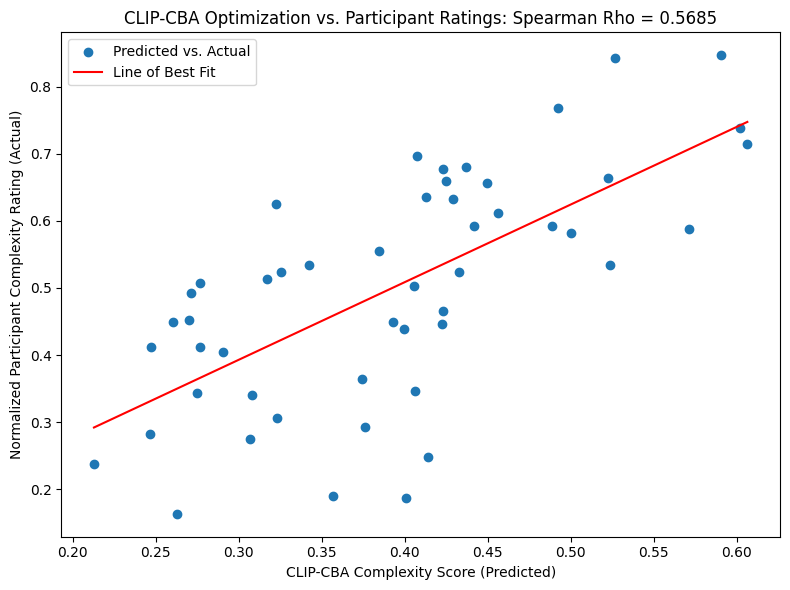

In [6]:
# Plot the scatter plot and line of best fit
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_true, label="Predicted vs. Actual")  # Predicted on x, Actual on y
plt.plot(line_x, line_y, color="red", label="Line of Best Fit")  # Best-fit line for predicted vs. actual
plt.xlabel("CLIP-CBA Complexity Score (Predicted)")
plt.ylabel("Normalized Participant Complexity Rating (Actual)")
plt.title(f"CLIP-CBA Optimization vs. Participant Ratings: Spearman Rho = {best_rho:.4f}")
plt.legend()
plt.tight_layout()
plt.show()